<a href="https://colab.research.google.com/github/mabataki2/AI-Class/blob/main/Week9/RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 정규화
df = pd.read_csv('/content/drive/MyDrive/Alcohol_Sales.csv')
data = df['S4248SM144NCEN'].values.reshape(-1, 1)

scaler = MinMaxScaler()
data = scaler.fit_transform(data)


In [18]:
# 2. 시퀀스 생성
window = 12  # 최근 12개월 → 다음달 예측
X, y = [], []
for i in range(len(data) - window):
    X.append(data[i:i + window])
    y.append(data[i + window])
X, y = np.array(X), np.array(y)

In [19]:
# 3. 훈련 데이터와 테스트 데이터 분리 (80% 훈련, 20% 테스트)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"y_test shape: {y_test.shape}")



X_train shape: (250, 12, 1)
X_test shape: (63, 12, 1)


In [20]:
# -----------------------------------------------------------
## 모델 1: SimpleRNN 정의 및 훈련
# -----------------------------------------------------------
print("\n--- SimpleRNN 모델 훈련 시작 ---")
model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, input_shape=(window, 1)),
    tf.keras.layers.Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')
model_rnn.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)
print("--- SimpleRNN 모델 훈련 완료 ---")

# SimpleRNN 예측 및 MSE 계산
test_pred_rnn = model_rnn.predict(X_test)
test_pred_rnn_inv = scaler.inverse_transform(test_pred_rnn)
test_mse_rnn = mean_squared_error(scaler.inverse_transform(y_test), test_pred_rnn_inv)
print(f"✅ SimpleRNN 테스트 데이터 MSE: {test_mse_rnn:.4f}")



--- SimpleRNN 모델 훈련 시작 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- SimpleRNN 모델 훈련 완료 ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step
✅ SimpleRNN 테스트 데이터 MSE: 461990.0370


In [21]:
# -----------------------------------------------------------
## 모델 2: LSTM 모델 정의 및 훈련
# -----------------------------------------------------------
print("\n--- LSTM 모델 훈련 시작 ---")
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(window, 1)),

    tf.keras.layers.Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)
print("--- LSTM 모델 훈련 완료 ---")

# LSTM 예측 및 MSE 계산
test_pred_lstm = model_lstm.predict(X_test)
test_pred_lstm_inv = scaler.inverse_transform(test_pred_lstm)
test_mse_lstm = mean_squared_error(scaler.inverse_transform(y_test), test_pred_lstm_inv)
print(f"✅ LSTM 테스트 데이터 MSE: {test_mse_lstm:.4f}")


--- LSTM 모델 훈련 시작 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- LSTM 모델 훈련 완료 ---
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
✅ LSTM 테스트 데이터 MSE: 1595272.4378


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


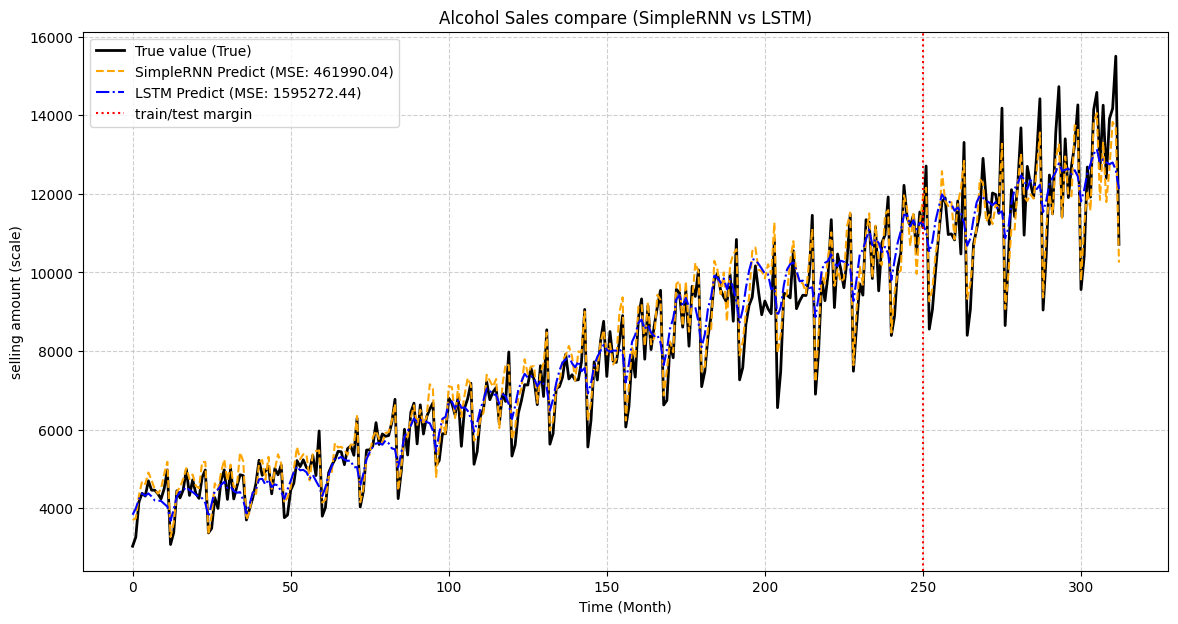

In [22]:
train_pred_rnn = model_rnn.predict(X_train)
train_pred_lstm = model_lstm.predict(X_train)
full_y_inv = scaler.inverse_transform(y)

# 전체 예측값 (훈련 + 테스트) 연결
# -----------------------------------------------------------
full_pred_rnn_inv = np.concatenate((scaler.inverse_transform(train_pred_rnn), test_pred_rnn_inv), axis=0)
full_pred_lstm_inv = np.concatenate((scaler.inverse_transform(train_pred_lstm), test_pred_lstm_inv), axis=0)



plt.figure(figsize=(14, 7))
plt.plot(full_y_inv, label='True value (True)', color='k', linewidth=2)

# SimpleRNN 결과
plt.plot(full_pred_rnn_inv, label=f'SimpleRNN Predict (MSE: {test_mse_rnn:.2f})', color='orange', linestyle='--')

# LSTM 결과
plt.plot(full_pred_lstm_inv, label=f'LSTM Predict (MSE: {test_mse_lstm:.2f})', color='blue', linestyle='-.')


# 훈련/테스트 데이터 경계선 표시
# 시퀀스 생성으로 인해 데이터프레임 크기가 window만큼 줄어든 것을 반영하여 경계선을 표시합니다.
plt.axvline(x=train_size, color='r', linestyle=':', linewidth=1.5, label='train/test margin')

plt.title('Alcohol Sales compare (SimpleRNN vs LSTM)')
plt.xlabel('Time (Month)')
plt.ylabel('selling amount (scale)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()